# Models

- Use team logs data to forecast point spread. 
- Start with two models:
    - Point Differential
    - Net Rating Diferential
    - I think these should be close, but, net rating should be a bit higher in early season. That's my guess.

In [316]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Point Differential

In [263]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

In [264]:
rolling_movs = (
    df
    .sort_values(by=['team', 'season', 'game_number'])
    .assign(
        cumulative_mov = lambda x: x.groupby(['team', 'season'])['mov'].cumsum(),
        rolling_mov = lambda x: x['cumulative_mov'] / x['game_number'],
        pre_game_mov = lambda x: x.groupby(['season', 'team'])['rolling_mov'].shift(1),
    )
)

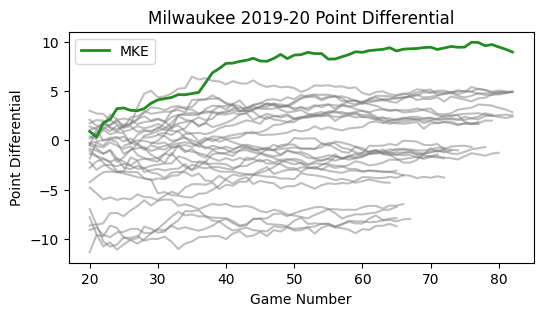

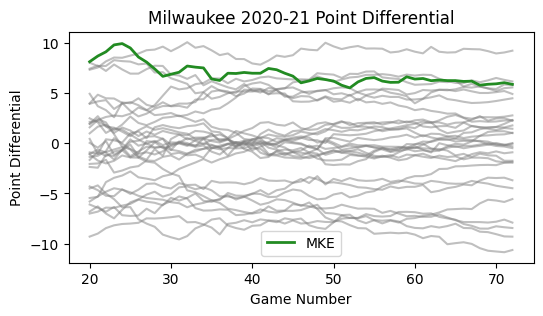

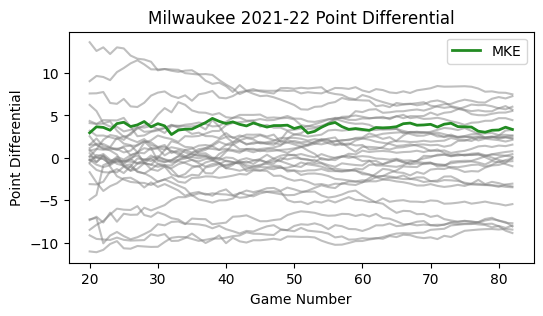

In [265]:
team = 'Milwaukee'

for season in ["2019-20", '2020-21', '2021-22']:

    fig, ax = plt.subplots(1,1, figsize=(6,3))


    (
        rolling_movs
        .query(f'season == "{season}"')
        .query(f'team != "{team}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
        .pivot_table(
            index='game_number',
            columns='team',
            values='rolling_mov'
        )
        .plot(
            legend=False,
            color='grey',
            alpha=0.5,
            ax=ax
        )
    )

    (
        rolling_movs
        .query(f'season == "{season}"')
        .query(f'team == "{team}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
        .plot(
            x='game_number',
            y='rolling_mov',
            color='forestgreen',
            ax=ax,
            label='MKE',
            lw=2
        )
    )

    plt.title(f'{team} {season} Point Differential')
    plt.xlabel('Game Number')
    plt.ylabel('Point Differential')
    plt.show()

## Predictions

- For each team, get their pregame rolling mov. Figure out how to get the home away thing.
- We can estimate a home-court advantage by including an intercept in the model.

In [266]:
predictions = (
    rolling_movs
    .pivot_table(
        index=['game_id'],
        columns='home_away',
        values='rolling_mov'
    )
    .reset_index()
    .merge(
        rolling_movs,
        on='game_id',
        how='left'
    )
    .query('home_away == "Home"')
    .assign(
        pre_game_mov_delta = lambda x: x['Home'] - x['Away']
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['game_id', 'Away', 'Home', 'team', 'opponent', 'point_spread', 'season', 'mov', 'pre_game_mov_delta']]
)

predictions

game_id       Away       Home          team  \
3      00004c0fcb8737eda21ad0bf471fb313   2.032258  -6.575758     Minnesota   
6      0003b7d6f3e13ef62d4c52f2bba13bfb  -1.238806   5.246377        Boston   
9      000459ce4258b763cc69835815de2ed1  -2.120000 -10.807692  Philadelphia   
12     00065fa8294eff0f8af256d96e5e5eb3   2.176471  -5.375000       Chicago   
14     000a456ce41df7390565ee0fd450284a   1.750000   0.714286        Denver   
...                                 ...        ...        ...           ...   
36406  ffd8c331af4e7e5ca91acb2a9d6eaefd  -0.518519   7.320000  OklahomaCity   
36408  ffd94973c6727c78f0d08c8b099cccc7  -6.951220   2.341463          Nets   
36412  ffdafc5dc8e7c417364fb6592a123456  -5.375000   2.625000       Indiana   
36415  ffeebbbde31ff209a61bbd131d67bf62  -2.795918   3.053571          Utah   
36417  fffce67b9f9f99af20da9d040a715c82  11.100000  -4.028571     Minnesota   

           opponent  point_spread   season  mov  pre_game_mov_delta  
3            Denver          -3.0  2010-11   -6           -8.608016  
6        Sacramento          -8.0  2018-19    6            6.485183  
9         Charlotte           8.0  2014-15    8           -8.687692  
12     OklahomaCity          -2.5  2009-10  -13           -7.551471  
14     Philadelphia          -5.0  2019-20    3           -1.035714  
...             ...           ...      ...  ...                 ...  
36406      Portland         -11.0  2015-16   16            7.838519  
36408  OklahomaCity          -5.5  2021-22  -21            9.292683  
36412    NewOrleans         -10.0  2011-12    9            8.000000  
36415    Sacramento          -9.0  2019-20   22            5.849490  
36417   GoldenState          12.0  2015-16   -5          -15.128571  

[13751 rows x 9 columns]

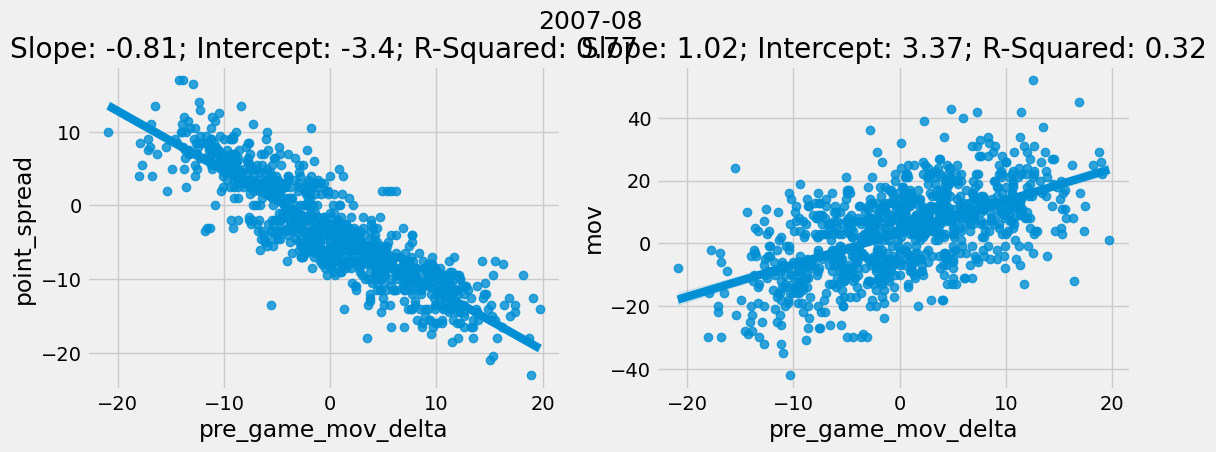

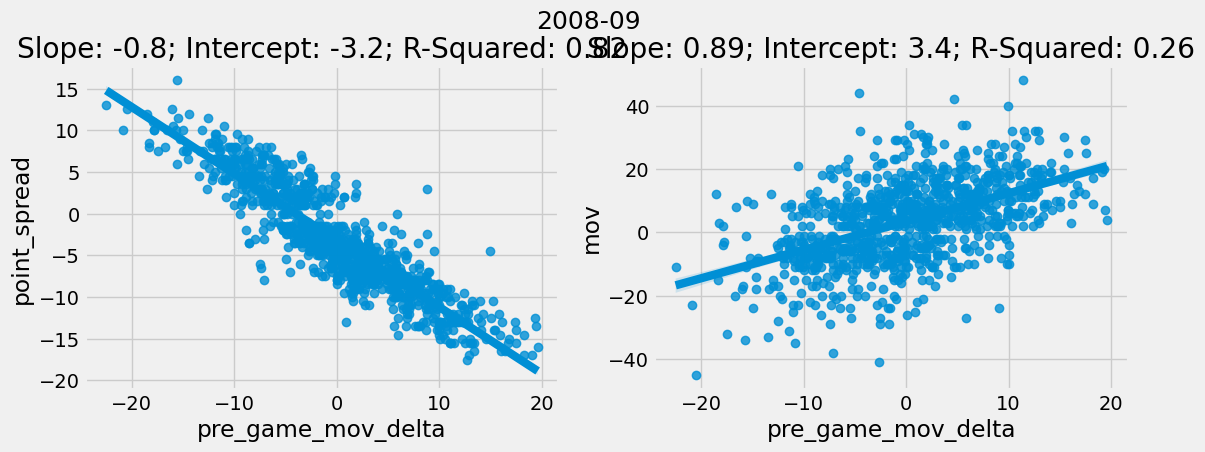

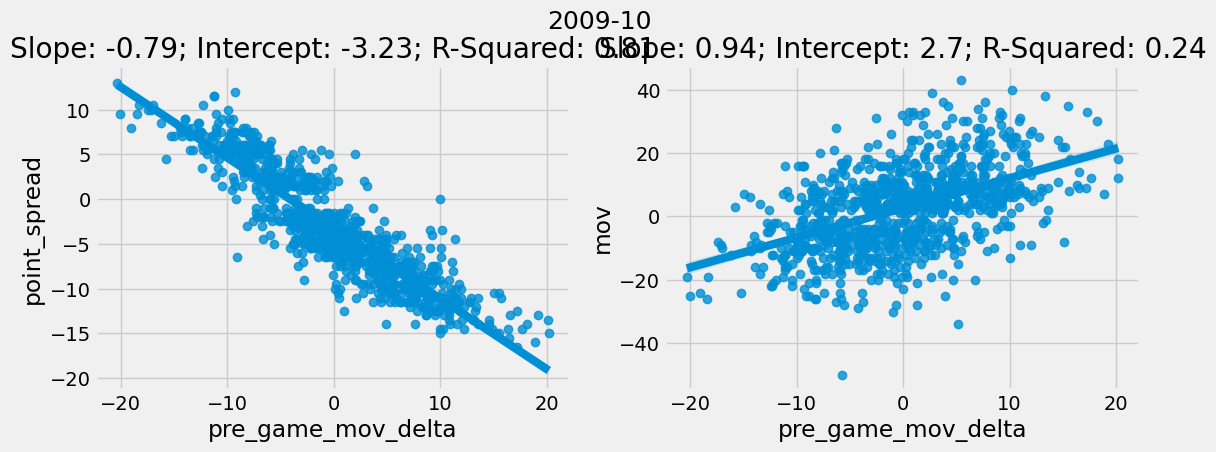

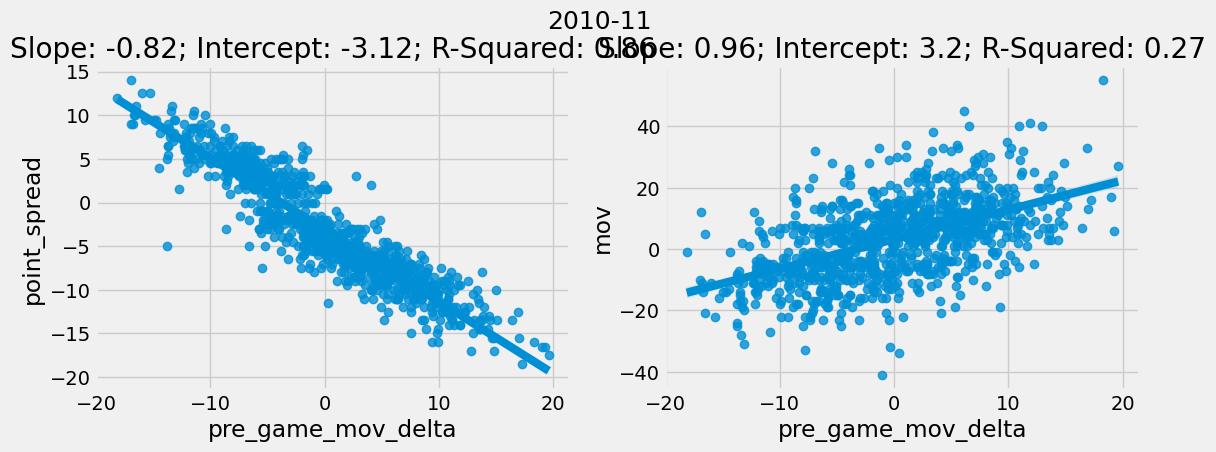

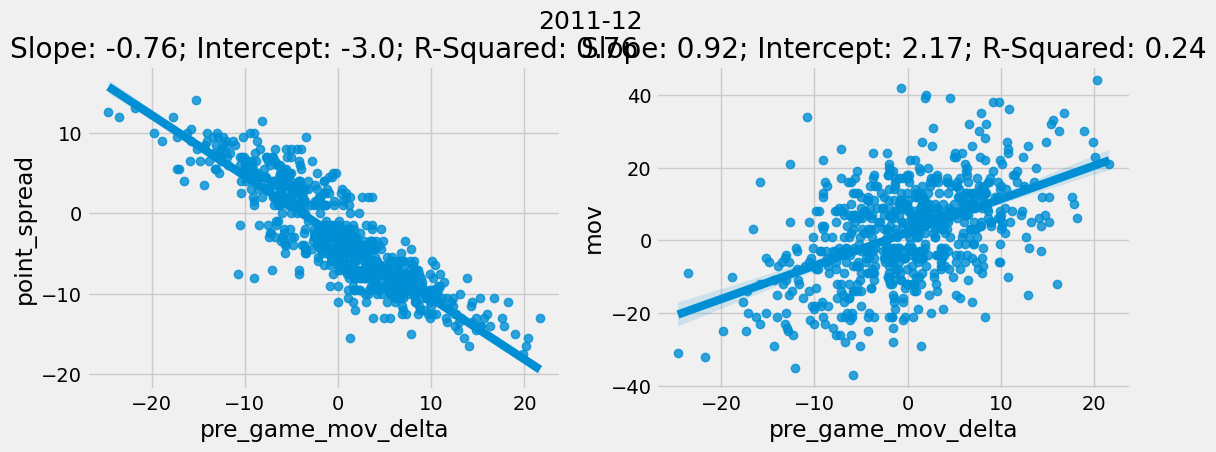

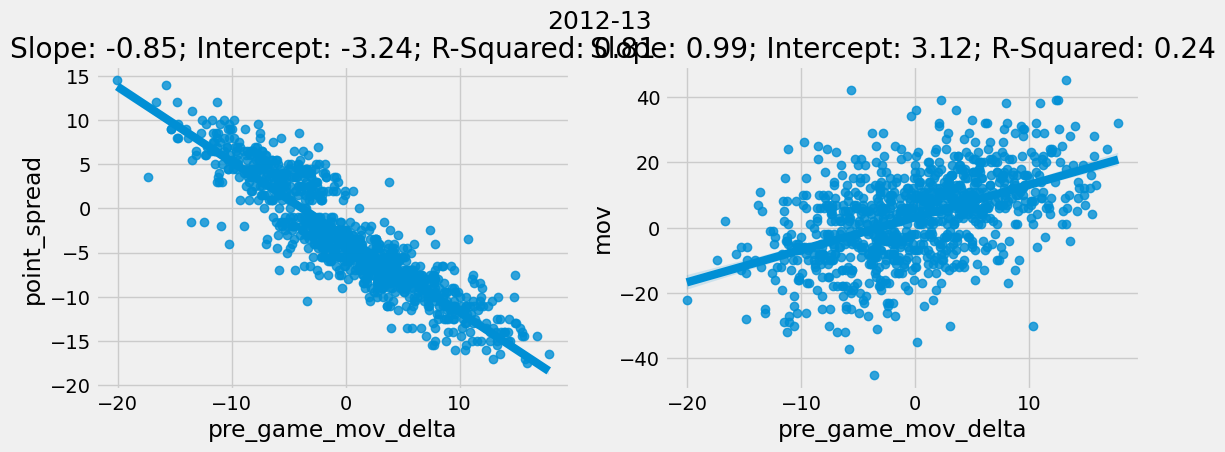

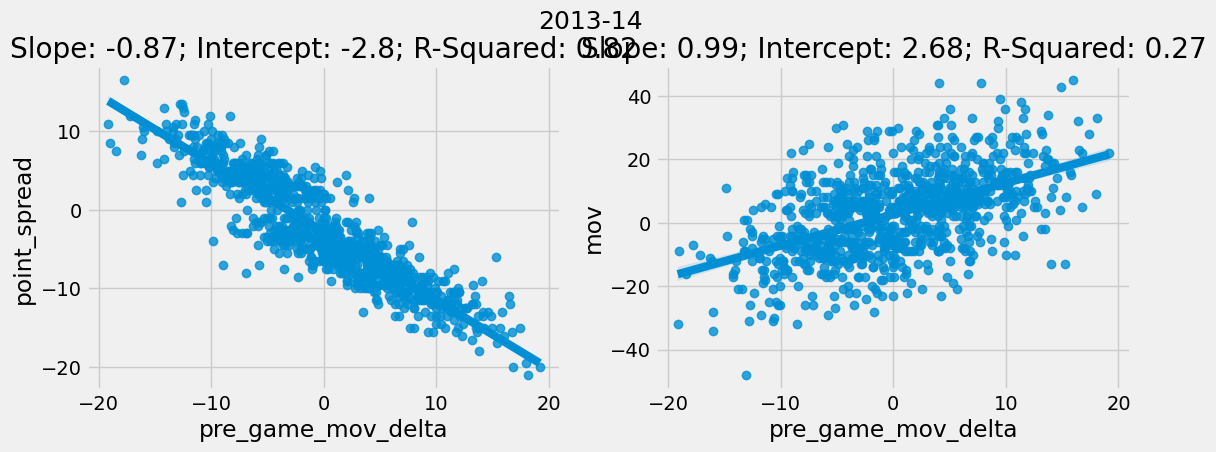

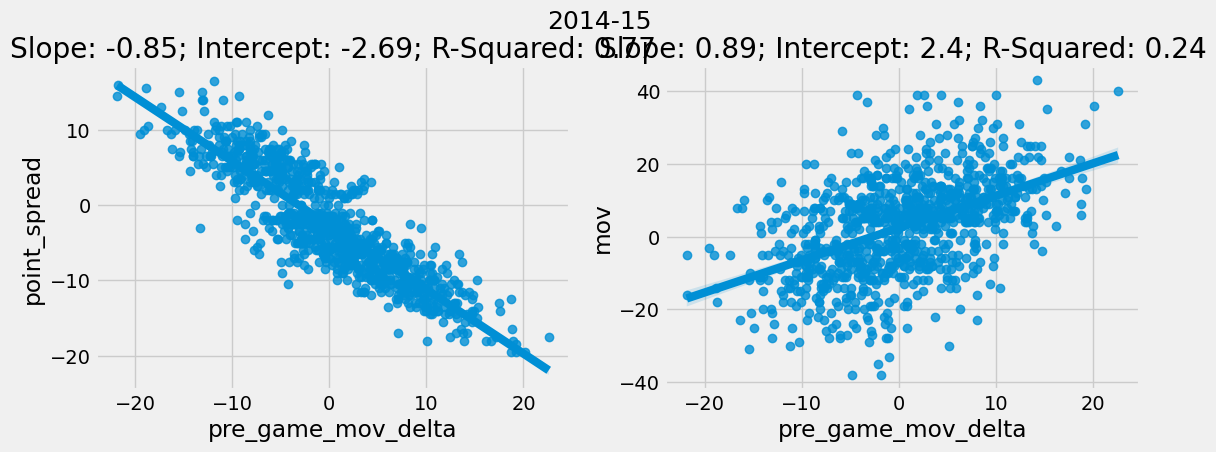

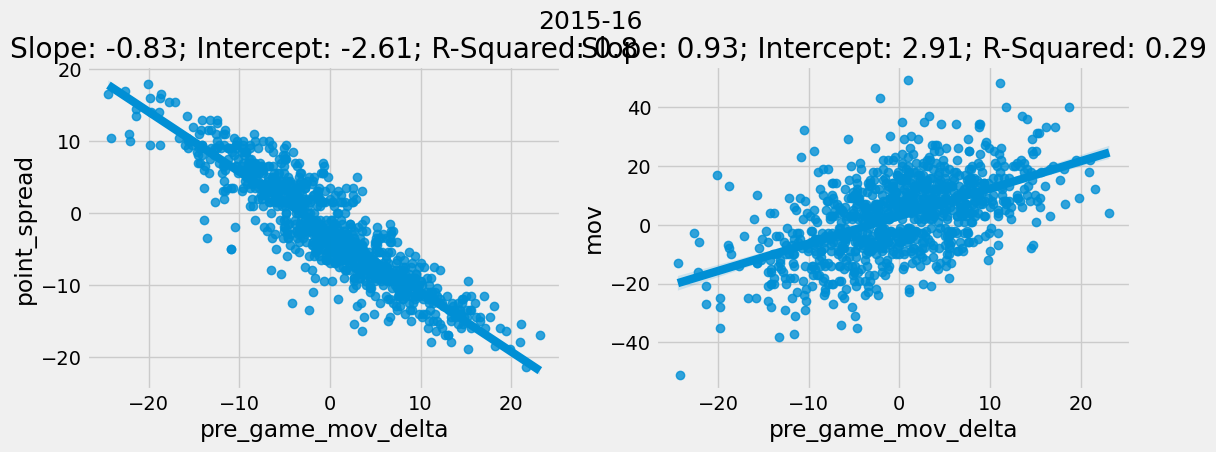

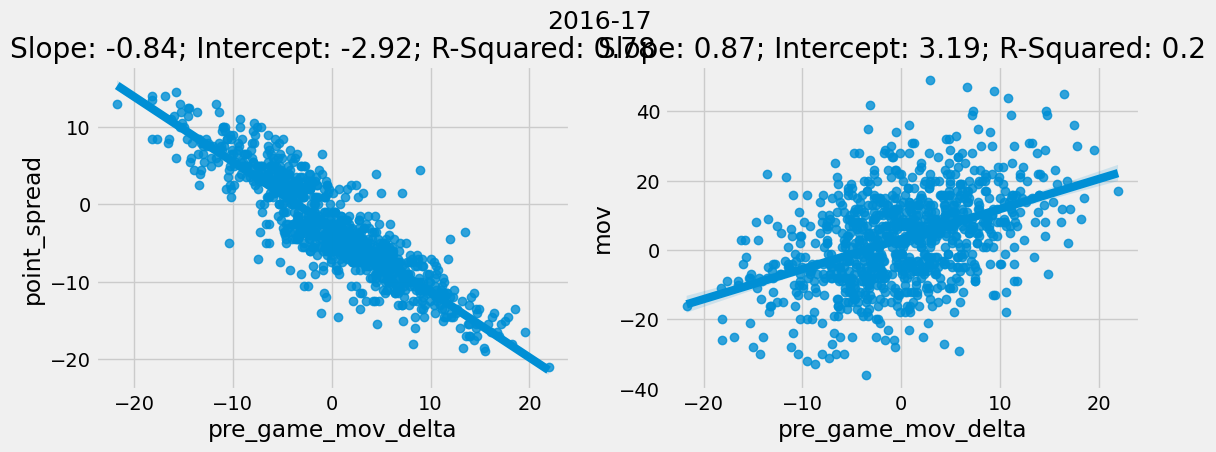

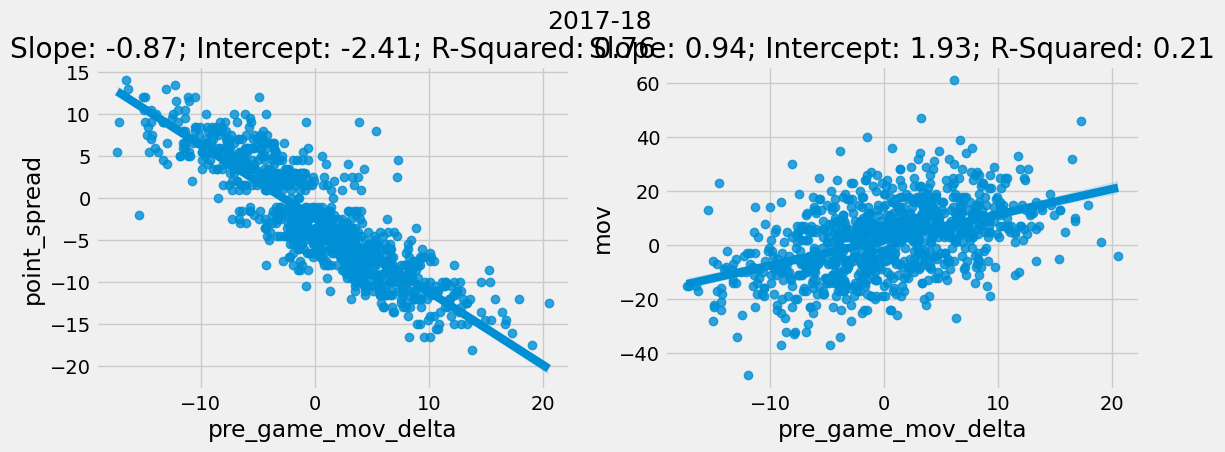

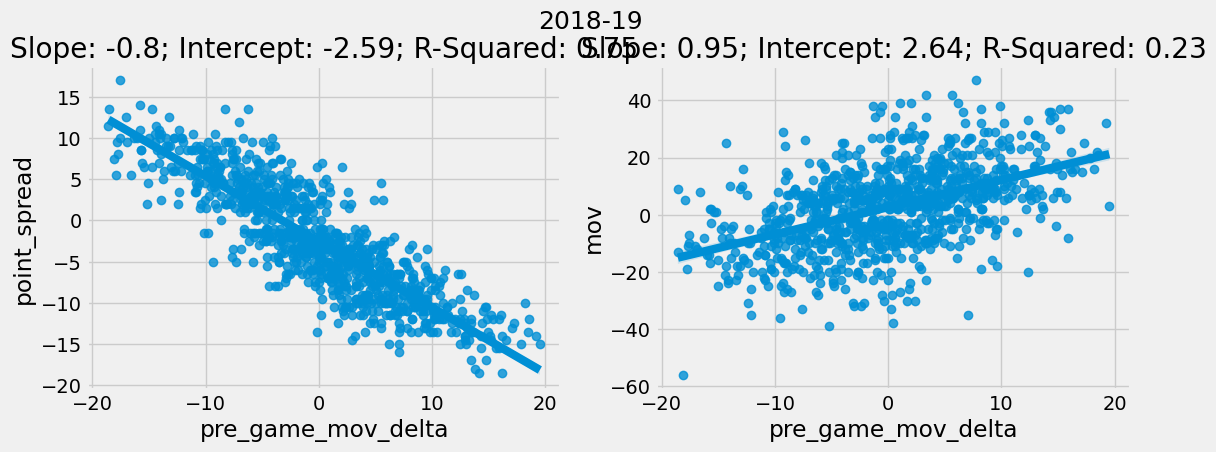

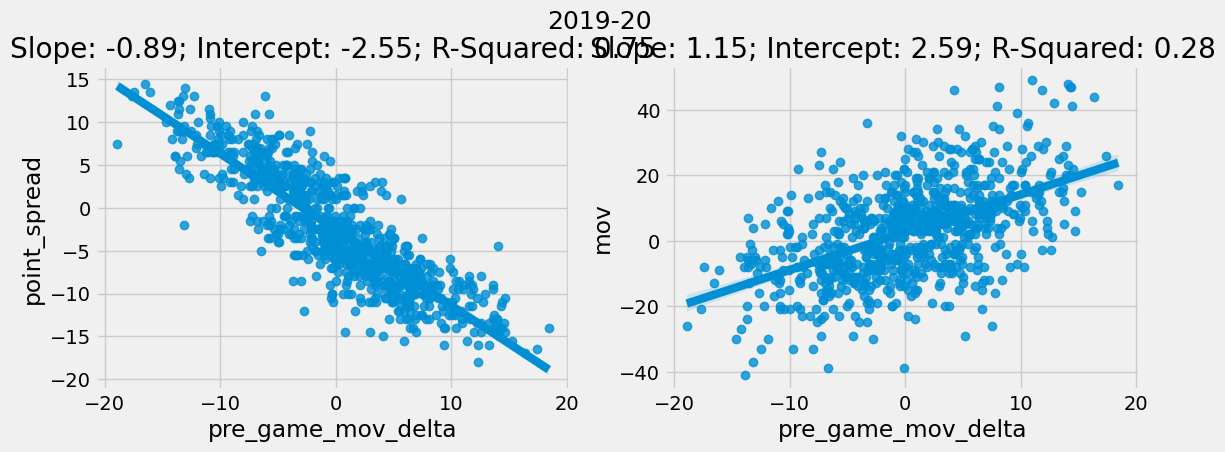

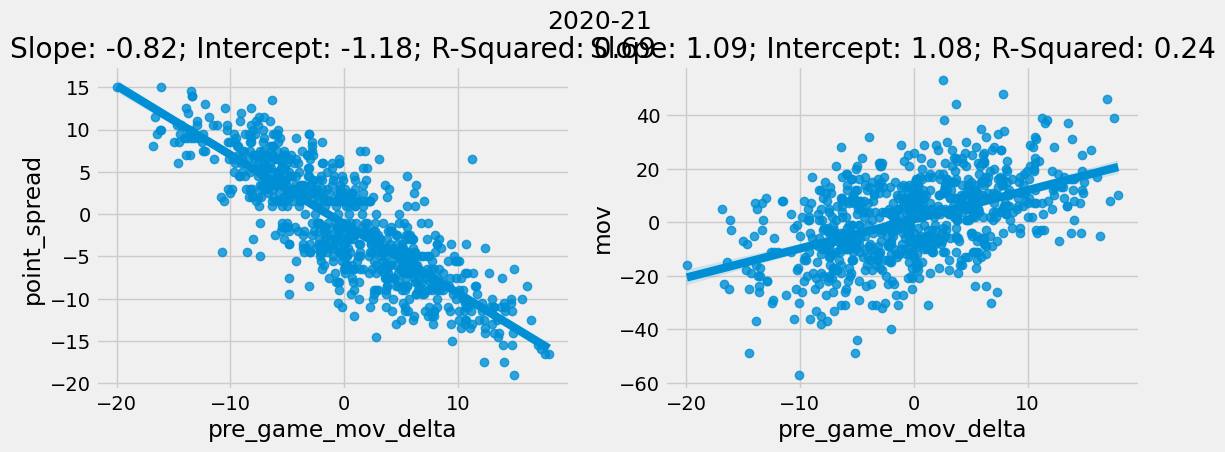

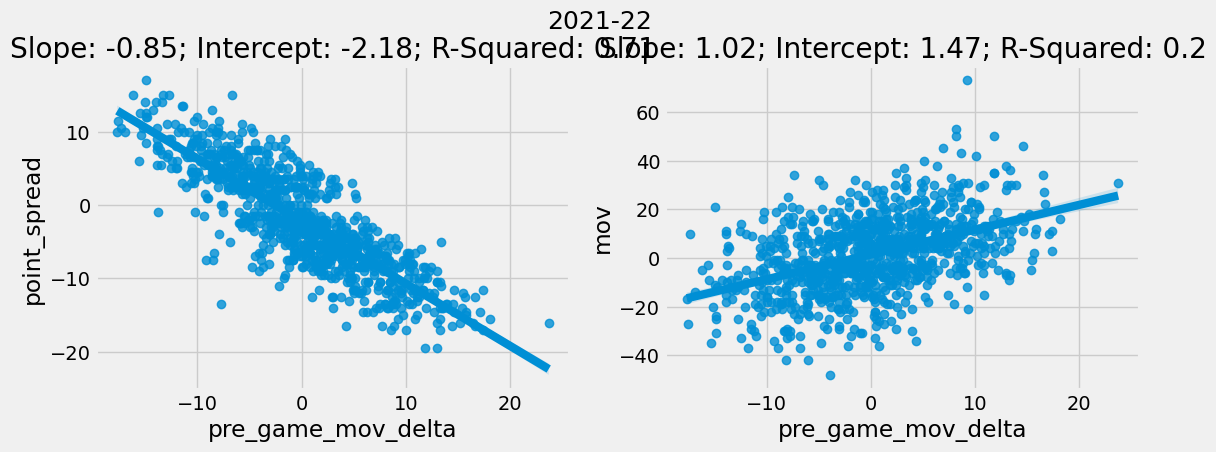

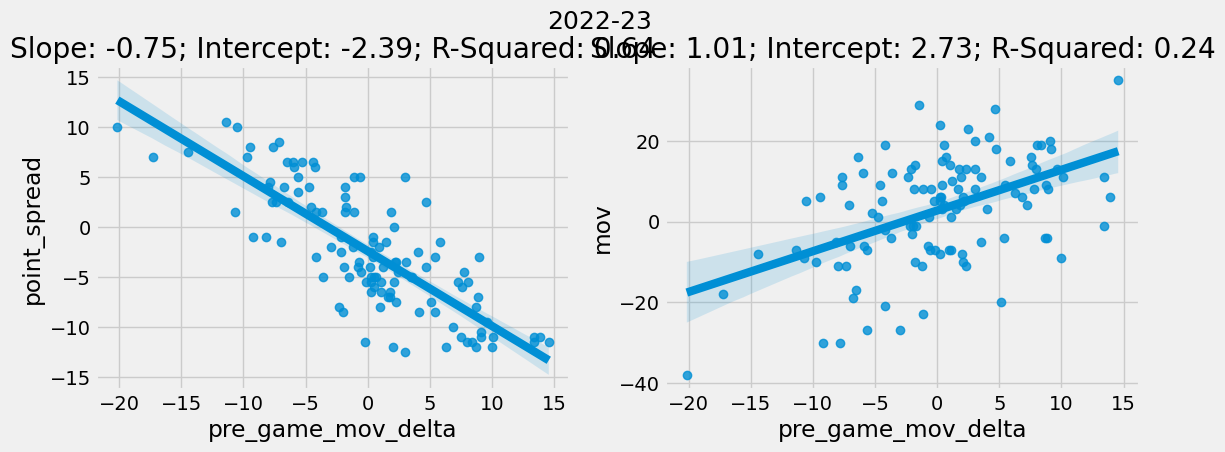

In [332]:
results = []

for season in predictions.sort_values(by='season').season.unique().tolist():

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

    model__spread = stats.linregress(
        x=predictions.query(f'season == "{season}"')['pre_game_mov_delta'],
        y=predictions.query(f'season == "{season}"')['point_spread'],
    )

    model__mov = stats.linregress(
        x=predictions.query(f'season == "{season}"')['pre_game_mov_delta'],
        y=predictions.query(f'season == "{season}"')['mov'],
    )

    summary__mov = f'Slope: {round(model__mov.slope,2)}; Intercept: {round(model__mov.intercept,2)}; R-Squared: {round(model__mov.rvalue ** 2, 2)}'
    summary__spread = f'Slope: {round(model__spread.slope,2)}; Intercept: {round(model__spread.intercept,2)}; R-Squared: {round(model__spread.rvalue ** 2, 2)}'


    sns.regplot(
        data=predictions.query(f'season == "{season}"'),
        x='pre_game_mov_delta',
        y='point_spread',
        ax=ax1,
    )

    ax1.set_title(summary__spread)


    sns.regplot(
        data=predictions.query(f'season == "{season}"'),
        x='pre_game_mov_delta',
        y='mov',
        ax=ax2,
    )

    ax2.set_title(summary__mov)

    plt.suptitle(season, size=18, y=1.02)
    plt.show()
    
    row = {
        'approach': 'MOV',
        'season': season,
        'r_squared': model__spread.rvalue**2,
        'home_court_advantage': model__spread.intercept
    }
    results.append(row)

array([<AxesSubplot: xlabel='season'>, <AxesSubplot: xlabel='season'>],
      dtype=object)

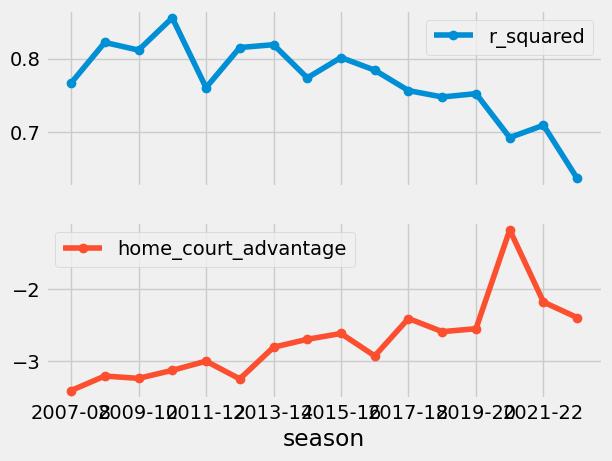

In [333]:
(
    pd.DataFrame(results)
    .plot(x='season', subplots=True, marker='o')
)

HCA decreases over time and point spread explains less of the spread variance over time.

## Pregame MOV vs Vegas

In [335]:
hca = (
    pd.DataFrame(results)
    .query('approach == "MOV"')
    .assign(
        shift = lambda x: x['home_court_advantage'].shift(1),
        ## Manual Covid Adjustment (Keep the pre-covid trend down in HCA going)
        hca = lambda x: x['shift'].transform(lambda s: -2.4 if s > -2 else s)
    )
    [['season', 'hca']]
)

hca.to_csv('../data/HCA by Season.csv', index=False)

In [338]:
seasons = [
    season for season in predictions.season.unique().tolist()
    if season != "2007-08"
]

rolling_mov_results = []

for season in seasons:

    subset = (
        predictions
        .query(f'season == "{season}"')
        .merge(
            hca,
            on='season',
            how='left'
        )
        .assign(
            Input = lambda x: -1 * x['hca'] + x['pre_game_mov_delta'],
            model_sign = lambda x: np.sign(x['Input']),
            outcome_sign = lambda x: np.sign(x['mov']),
            model_right = lambda x: x['model_sign'] == x['outcome_sign']
        )
    )

    X = subset['Input']
    y = subset['mov']

    model = sm.OLS(y, X)
    results = model.fit()

    row = {
        'season': season,
        'rsquared': results.rsquared,
        'batting_average': subset.model_right.mean()
    }
    
    rolling_mov_results.append(row)

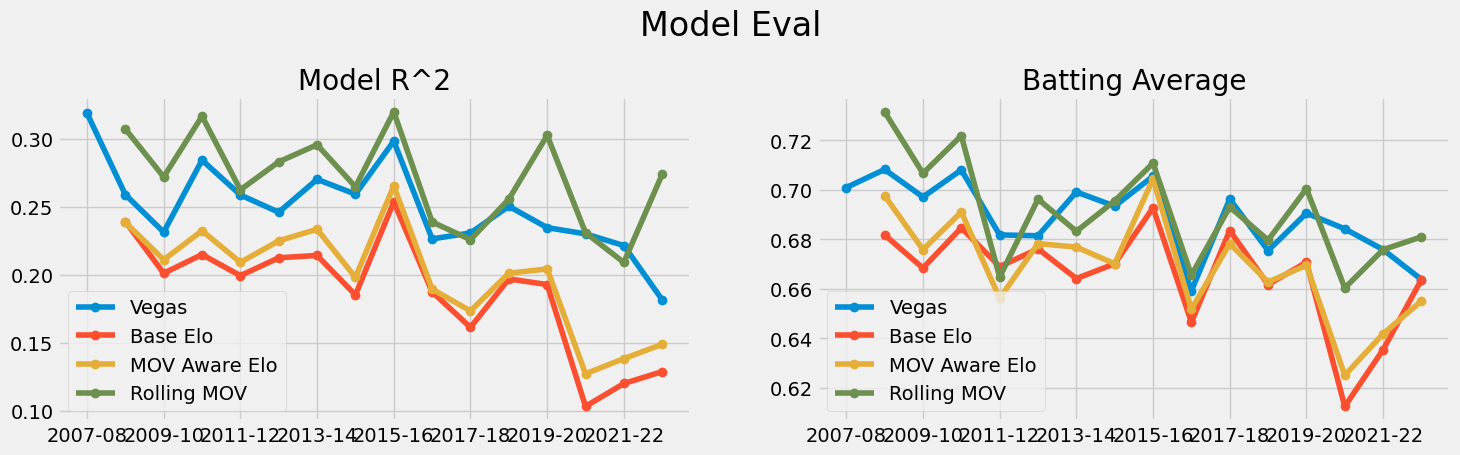

In [339]:
style.use('fivethirtyeight')

mov_results = (
    pd.DataFrame(rolling_mov_results)
    .melt(
        id_vars='season',
        var_name='feature_name',
        value_name='Rolling MOV'
    )
    .merge(
        pd.read_csv('../data/Elo MOV Aware Results.csv'),
        how='right',
        on=['season', 'feature_name']
    )
    .merge(
        pd.read_csv('../data/Vegas Benchmarks.csv'),
        how='right',
        on=['season', 'feature_name']
    )
)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

(
    mov_results
    .query('feature_name == "rsquared"')
    .plot(
        x='season',
        y=['Vegas', 'Base Elo', 'MOV Aware Elo', 'Rolling MOV'],
        ax=ax1,
        marker='o',
        legend=True,
        title='Model R^2'
    )
)

(
    mov_results
    .query('feature_name == "batting_average"')
    .plot(
        x='season',
        y=['Vegas','Base Elo', 'MOV Aware Elo', 'Rolling MOV'],
        ax=ax2,
        marker='o',
        legend=True,
        title='Batting Average'
    )
)

plt.suptitle('Model Eval', y=1.1, size=24)

ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

This feels wrong-ish, IDK why rolling MOV r^2 would be higher than vegas. There must be some pull forward happening here. Preobably need to go back and check.

In [341]:
mov_results.to_csv('../data/MOV Results.csv', index=False)

## Net Rating Differential

In [269]:
mapping = pd.read_csv('../data/mapping__nba_teams.csv')

mapping.head()

team_id             team_name        team
0  1610612737         Atlanta Hawks     Atlanta
1  1610612738        Boston Celtics      Boston
2  1610612739   Cleveland Cavaliers   Cleveland
3  1610612740  New Orleans Pelicans  NewOrleans
4  1610612740   New Orleans Hornets  NewOrleans

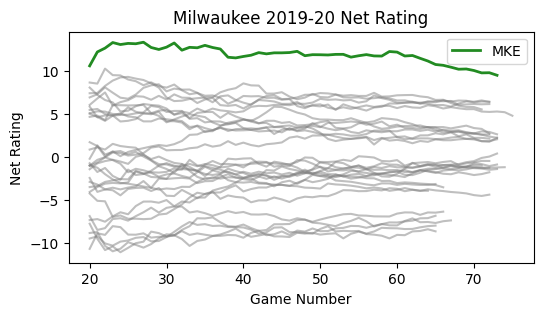

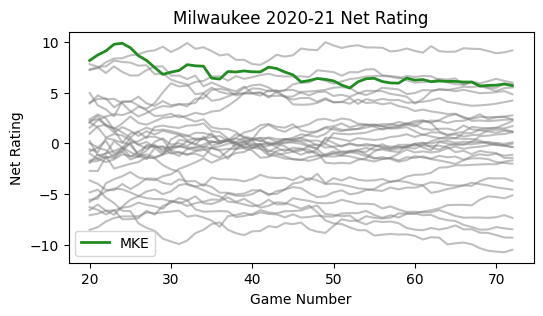

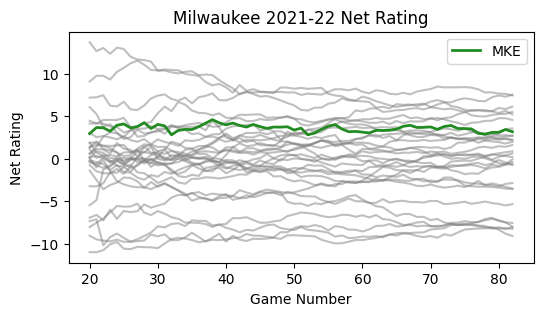

In [270]:
for season in ["2019-20", '2020-21', '2021-22']:

    rolling_rpm = (
        pd.read_csv(f'../data/nba_stats/{season}_teamgamelogs_Advanced.csv')
        .assign(
            dt = lambda x: x['game_date'].transform(lambda s: s.split('T')[0]),
            rpm_48 = lambda x: 48 * x['net_rating'] / x['min'],
            season = lambda x: x['season_year']
        )
        .sort_values(
            by='dt'
        )
        .merge(
            mapping,
            on=['team_name', 'team_id'],
            how='left'
        )
        .sort_values(
            by=['team', 'dt']
        )
        .reset_index()
        .reset_index()
        .assign(
            game_number = lambda x: x.groupby(['season', 'team'])['level_0'].rank(method="first", ascending=True),
            cumulative_rpm = lambda x: x.groupby(['team', 'season'])['rpm_48'].cumsum(),
            rolling_rpm = lambda x: x['cumulative_rpm'] / x['game_number'],
            pre_game_rpm = lambda x: x.groupby(['season', 'team'])['rolling_rpm'].shift(1),
        )
    )

    team = 'Milwaukee'



    fig, ax = plt.subplots(1,1, figsize=(6,3))


    (
        rolling_rpm
        .query(f'season == "{season}"')
        .query(f'team != "{team}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
        .pivot_table(
            index='game_number',
            columns='team',
            values='rolling_rpm'
        )
        .plot(
            legend=False,
            color='grey',
            alpha=0.5,
            ax=ax
        )
    )

    (
        rolling_rpm
        .query(f'season == "{season}"')
        .query(f'team == "{team}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
        .plot(
            x='game_number',
            y='rolling_rpm',
            color='forestgreen',
            ax=ax,
            label='MKE',
            lw=2
        )
    )

    plt.title(f'{team} {season} Net Rating')
    plt.xlabel('Game Number')
    plt.ylabel('Net Rating')
    plt.show()

In [271]:
data = (
    df
    .query('season == "2021-22"')
    .query('home_away == "Home"')
    [['team', 'season', 'opponent', 'point_spread', 'dt', 'mov']]
    .merge(
        (
            rolling_rpm
            [[ 'dt', 'season', 'team', 'pre_game_rpm']]
            .rename(columns={'pre_game_rpm': 'home_rating'})
        ),
        on=['season', 'team', 'dt'],
        how='left'
    )
    .merge(
        (
            rolling_rpm
            [[ 'dt', 'season', 'team', 'pre_game_rpm', 'game_number']]
            .rename(
                columns={
                    'pre_game_rpm': 'away_rating',
                    'team': 'opponent'
                }
            )
        ),
        on=['season', 'opponent', 'dt'],
        how='left'
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    .assign(
        rating_delta = lambda x: x['home_rating'] - x['away_rating']
    )
)

data

team   season      opponent  point_spread          dt  mov  \
9        Atlanta  2021-22       NewYork          -8.0  2021-11-27   -9   
10       Atlanta  2021-22  Philadelphia          -2.5  2021-12-03   -2   
11       Atlanta  2021-22     Charlotte          -7.5  2021-12-05   -3   
12       Atlanta  2021-22          Nets          -2.0  2021-12-10   -8   
13       Atlanta  2021-22       Houston         -10.5  2021-12-13   -6   
...          ...      ...           ...           ...         ...  ...   
1225  Washington  2021-22   GoldenState           7.0  2022-03-27    8   
1226  Washington  2021-22       Chicago           4.0  2022-03-29  -13   
1227  Washington  2021-22       Orlando          -4.0  2022-03-30   17   
1228  Washington  2021-22        Dallas           7.5  2022-04-01   32   
1229  Washington  2021-22       NewYork           3.5  2022-04-08  -22   

      home_rating  away_rating  game_number  rating_delta  
9        3.030000    -0.599819         20.0      3.629819  
10       2.659091     1.531034         23.0      1.128056  
11       2.500000    -0.031682         25.0      2.531682  
12       2.628000     3.088000         26.0     -0.460000  
13       2.188462    -5.621843         27.0      7.810305  
...           ...          ...          ...           ...  
1225    -3.315948     5.683962         75.0     -8.999910  
1226    -3.179246    -0.011975         76.0     -3.167271  
1227    -3.339523    -7.737959         77.0      4.398436  
1228    -3.078477     3.164004         78.0     -6.242480  
1229    -3.083303    -0.844815         81.0     -2.238487  

[949 rows x 10 columns]

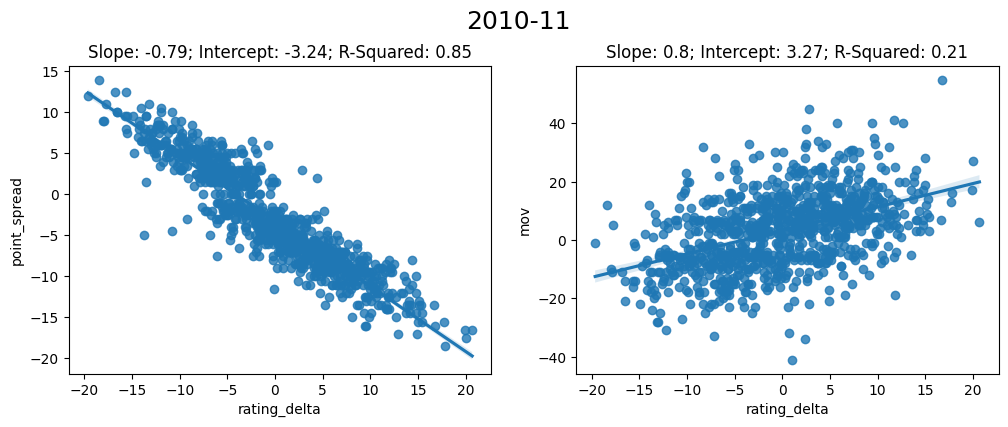

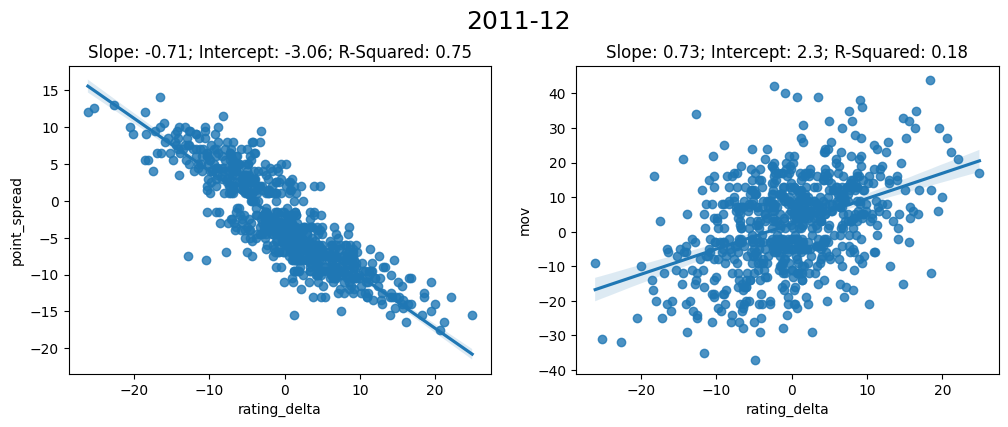

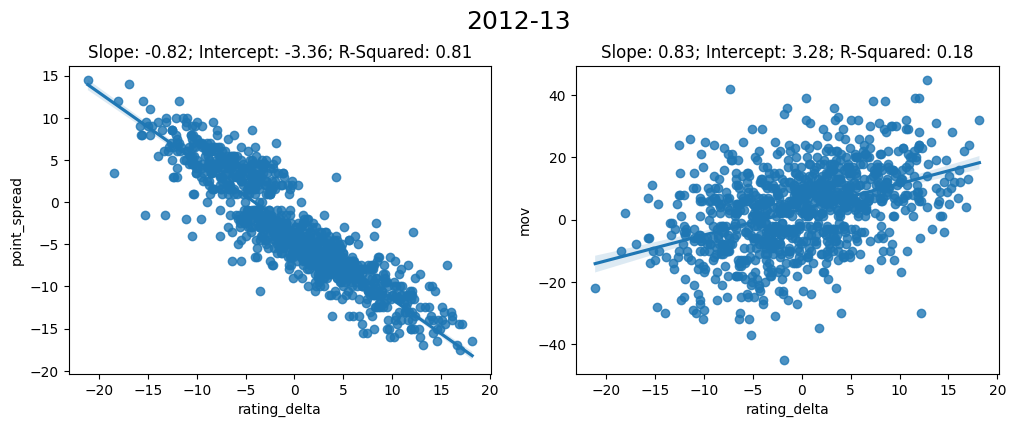

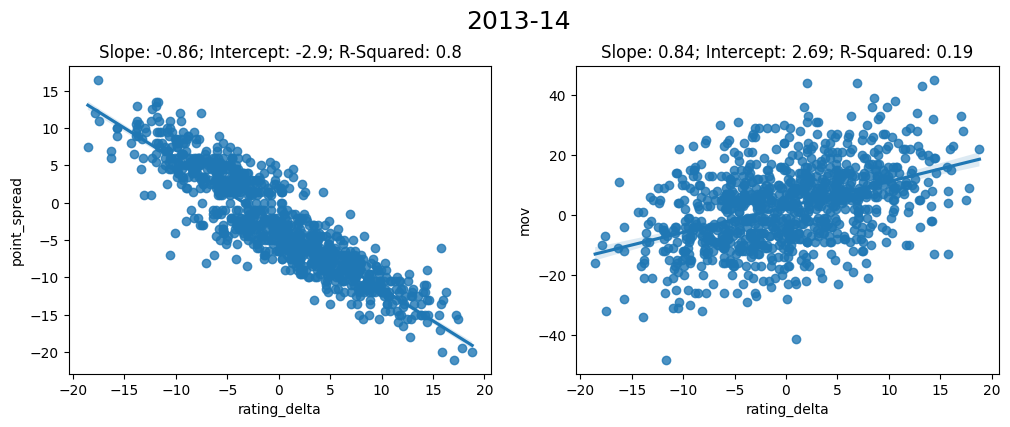

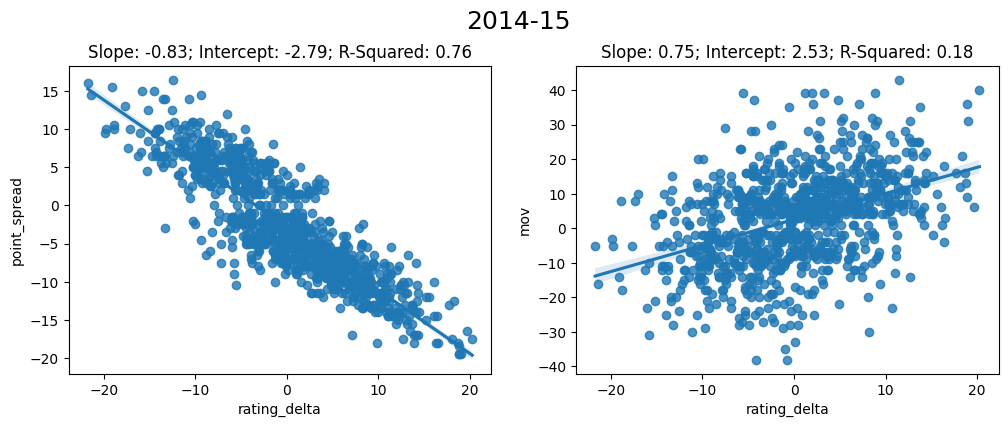

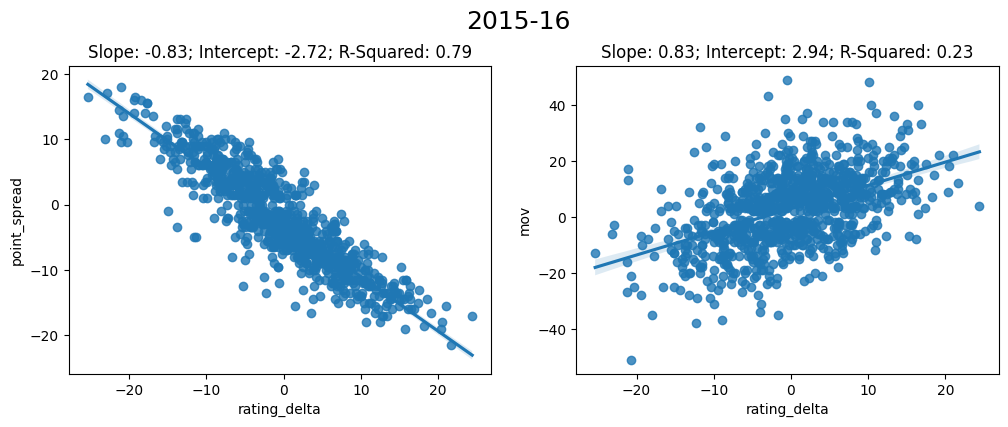

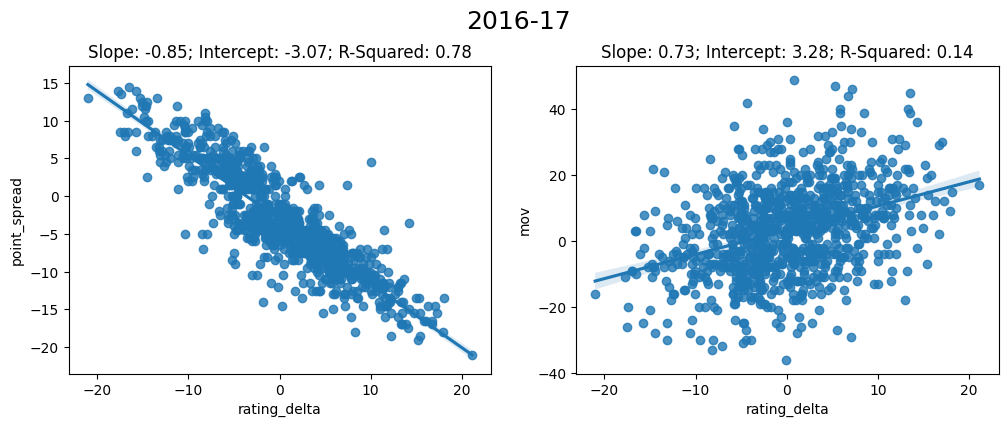

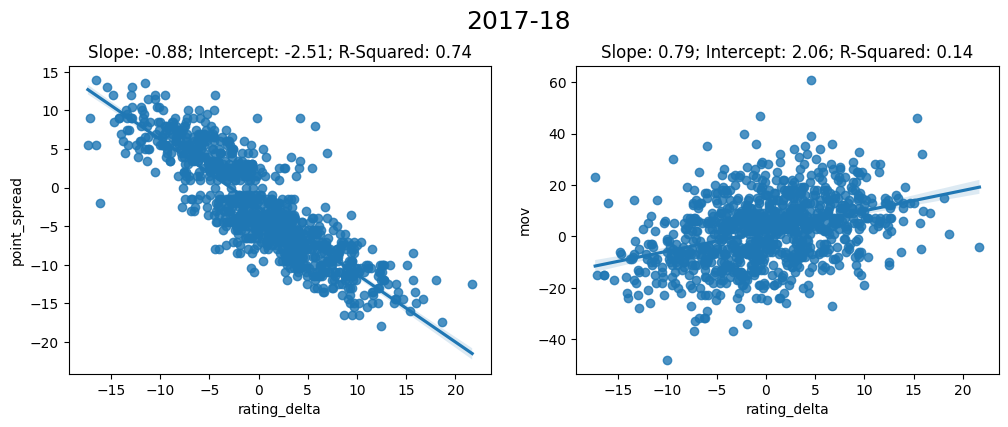

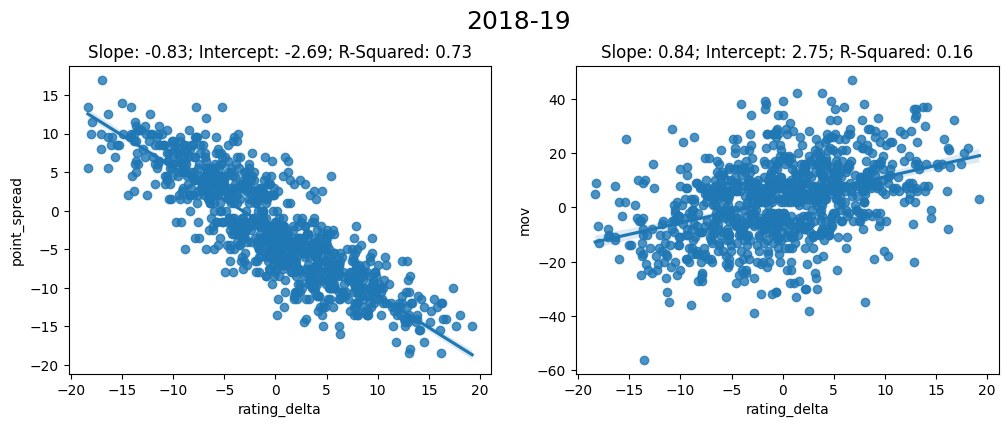

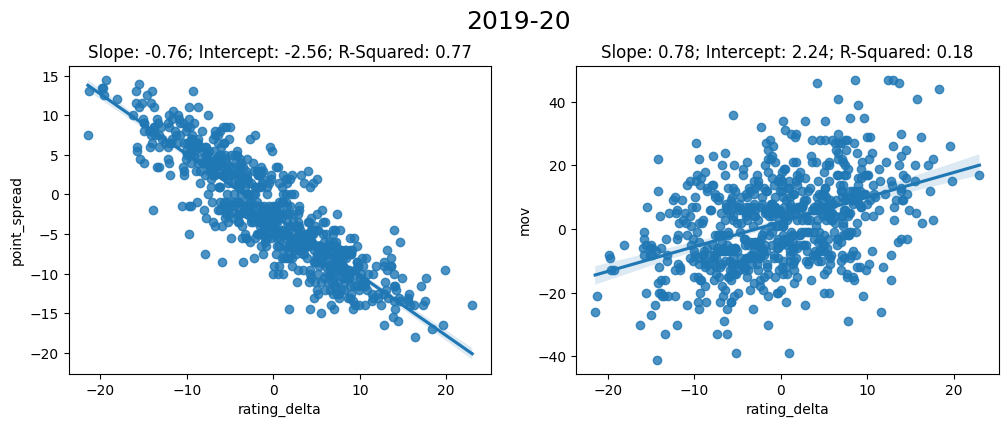

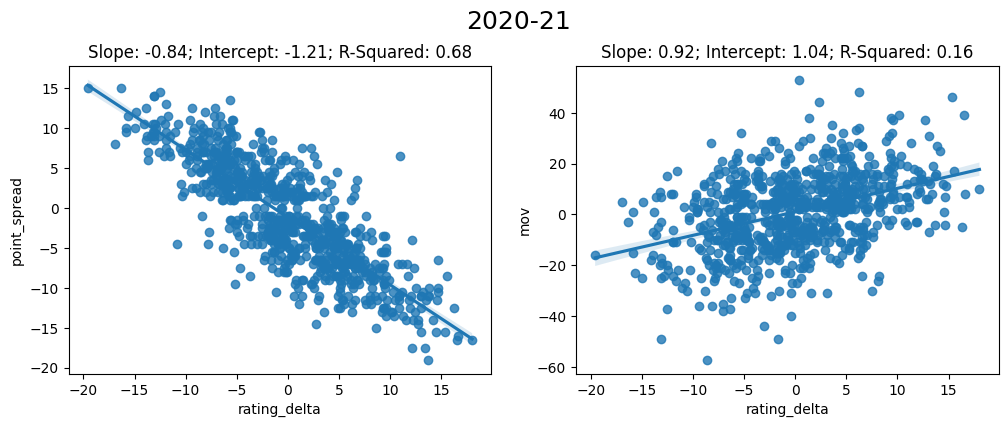

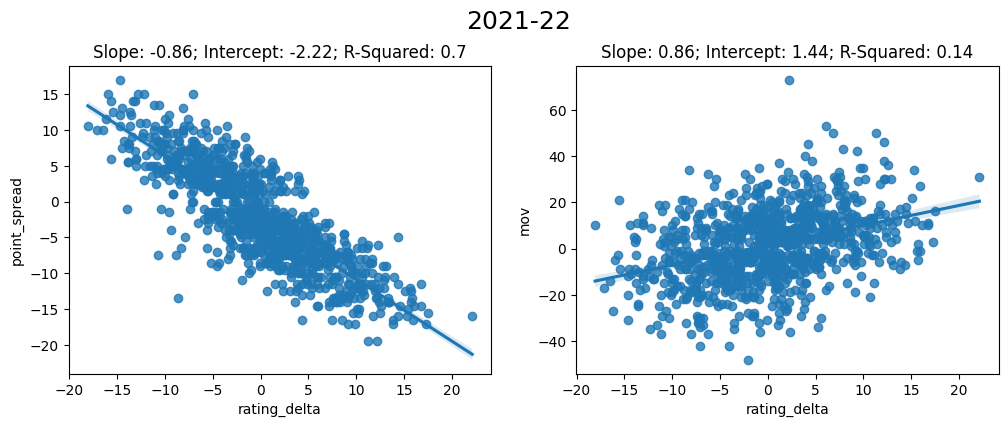

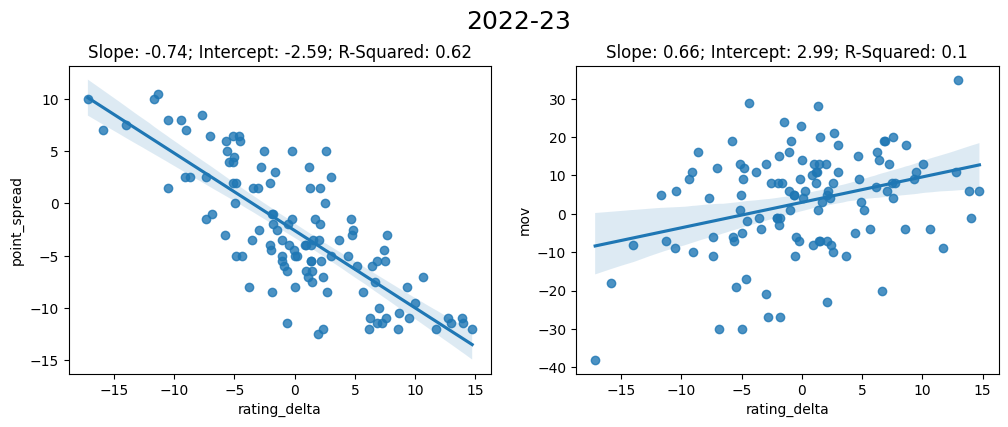

In [272]:
for season in predictions.query('season >= "2010-11"').sort_values(by='season').season.unique().tolist():
    
    rolling_rpm = (
        pd.read_csv(f'../data/nba_stats/{season}_teamgamelogs_Advanced.csv')
        .assign(
            dt = lambda x: x['game_date'].transform(lambda s: s.split('T')[0]),
            rpm_48 = lambda x: 48 * x['net_rating'] / x['min'],
            season = lambda x: x['season_year']
        )
        .sort_values(
            by='dt'
        )
        .merge(
            mapping,
            on=['team_name', 'team_id'],
            how='left'
        )
        .sort_values(
            by=['team', 'dt']
        )
        .reset_index()
        .reset_index()
        .assign(
            game_number = lambda x: x.groupby(['season', 'team'])['level_0'].rank(method="first", ascending=True),
            cumulative_rpm = lambda x: x.groupby(['team', 'season'])['rpm_48'].cumsum(),
            rolling_rpm = lambda x: x['cumulative_rpm'] / x['game_number'],
            pre_game_rpm = lambda x: x.groupby(['season', 'team'])['rolling_rpm'].shift(1),
        )
    )

    data = (
        df
        .query(f'season == "{season}"')
        .query('home_away == "Home"')
        [['team', 'season', 'opponent', 'point_spread', 'dt', 'mov']]
        .merge(
            (
                rolling_rpm
                [[ 'dt', 'season', 'team', 'pre_game_rpm']]
                .rename(columns={'pre_game_rpm': 'home_rating'})
            ),
            on=['season', 'team', 'dt'],
            how='left'
        )
        .merge(
            (
                rolling_rpm
                [[ 'dt', 'season', 'team', 'pre_game_rpm', 'game_number']]
                .rename(
                    columns={
                        'pre_game_rpm': 'away_rating',
                        'team': 'opponent'
                    }
                )
            ),
            on=['season', 'opponent', 'dt'],
            how='left'
        )
        .query('game_number >= 20')
        .query('game_number <= 82')
        .assign(
            rating_delta = lambda x: x['home_rating'] - x['away_rating']
        )
    )

    data
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

    model__spread = stats.linregress(
        x=data['rating_delta'],
        y=data['point_spread'],
    )

    model__mov = stats.linregress(
        x=data['rating_delta'],
        y=data['mov'],
    )

    summary__mov = f'Slope: {round(model__mov.slope,2)}; Intercept: {round(model__mov.intercept,2)}; R-Squared: {round(model__mov.rvalue ** 2, 2)}'
    summary__spread = f'Slope: {round(model__spread.slope,2)}; Intercept: {round(model__spread.intercept,2)}; R-Squared: {round(model__spread.rvalue ** 2, 2)}'


    sns.regplot(
        data=data,
        x='rating_delta',
        y='point_spread',
        ax=ax1,
    )

    ax1.set_title(summary__spread)


    sns.regplot(
        data=data,
        x='rating_delta',
        y='mov',
        ax=ax2,
    )

    ax2.set_title(summary__mov)

    plt.suptitle(season, size=18, y=1.02)
    plt.show()

    row = {
        'approach': 'Net Rating',
        'season': season,
        'r_squared': model__spread.rvalue**2,
        'home_court_advantage': model__spread.intercept
    }
    results.append(row)

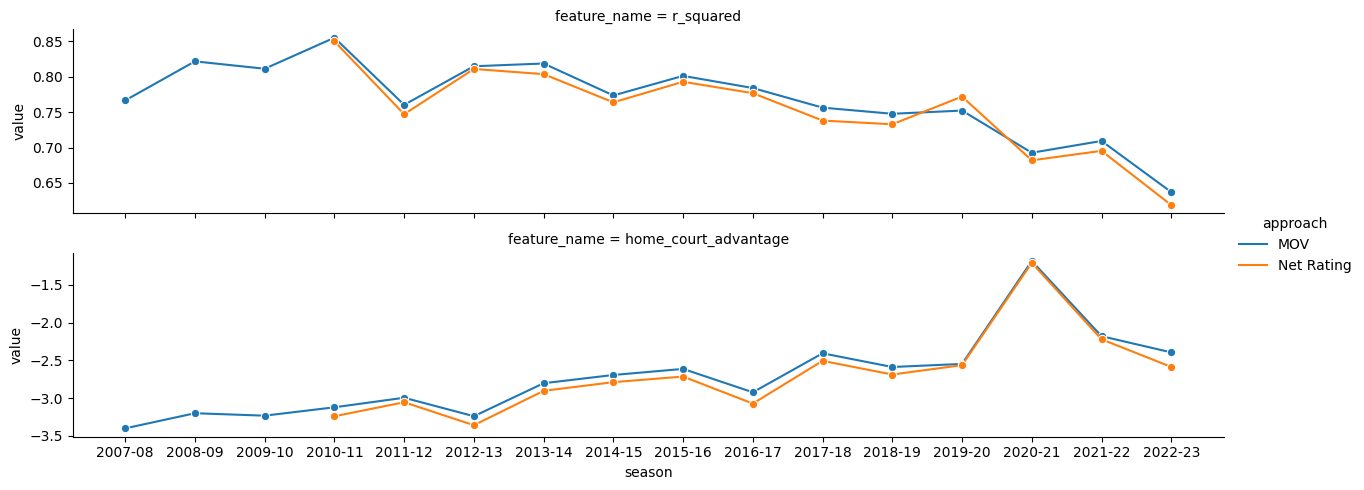

In [273]:
sns.relplot(
    data=(
        pd.DataFrame(results)
        .melt(
            id_vars=['approach', 'season'],
            var_name='feature_name',
        )
    ),
    x='season',
    y='value',
    hue='approach',
    col='feature_name',
    kind='line',
    facet_kws={'sharey': False},
    marker='o',
    height=2.5,
    aspect=5,
    col_wrap=1
)

Interesting. Net rating doesn't do much better than mov. Hmmmmmmmmmmmmm. Is it time to go to player models? Well, we should look at HCA by team; presumably Denver/Utah will have a bigger HCA. Also, something about travel will be important too. Travel and time --> west coast time moving to east coast and playing a noon game should be bad for west coast team. East coast team going to west coast and playing a 7pm game should also be be bad.

## HCA by City

- Each city/season gets a linear regression for intercept.

In [274]:
def get_regression_outputs(team, season):
    subset = predictions.query(f'team == "{team}"').query(f'season == "{season}"')
    
    model = stats.linregress(
        x=subset['pre_game_mov_delta'],
        y=subset['point_spread']
    )
    
    intercept = model.intercept
    
    return intercept

In [275]:
seasons = predictions.sort_values(by='season').query('season != "2022-23"').season.unique().tolist()
teams = predictions.team.unique().tolist()

team_based_results = []

for season in seasons:
    for team in teams:
        try:
            row = {
                'team': team,
                'season': season,
                'home_court_advantage': get_regression_outputs(team, season)
            }

            team_based_results.append(row)
        except Exception as e:
            pass

In [276]:
hca = pd.DataFrame(team_based_results)

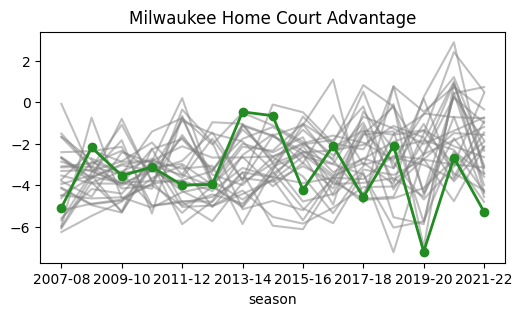

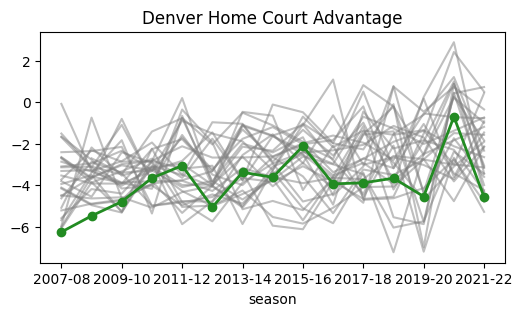

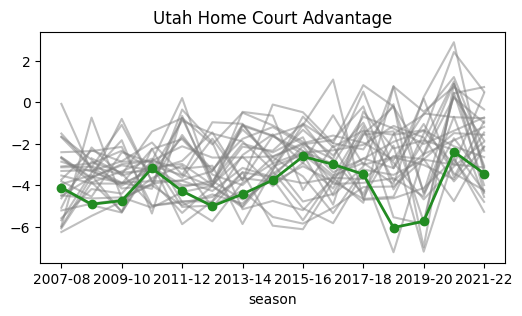

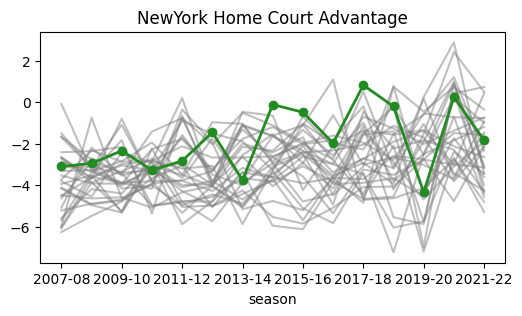

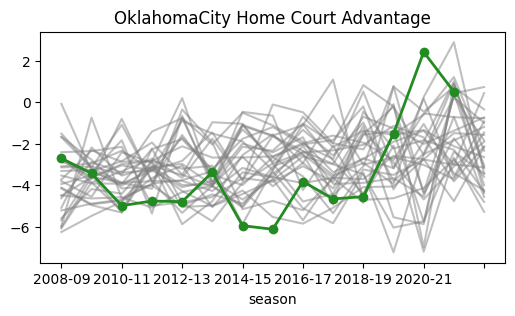

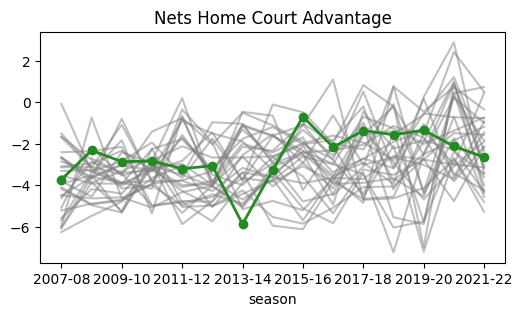

In [277]:
teams = ['Milwaukee', 'Denver', 'Utah', 'NewYork', 'OklahomaCity', 'Nets']


for team in teams:

    fig, ax = plt.subplots(1,1, figsize=(6,3))


    (
        hca
        .query(f'team != "{team}"')
        .pivot_table(
            index='season',
            columns='team',
            values='home_court_advantage'
        )

        .plot(
            legend=False,
            color='grey',
            alpha=0.5,
            ax=ax
        )
    )

    (
        hca
        .query(f'team == "{team}"')
        .pivot_table(
            index='season',
            columns='team',
            values='home_court_advantage'
        )
        .plot(
            legend=False,
            color='forestgreen',
            alpha=1,
            ax=ax,
            lw=2,
            marker='o'
        )
    )
    
    plt.title(f'{team} Home Court Advantage')

    plt.show()

Interesting, I wonder how much we could improve the forecast model with this. Probably need to handle lineups first, then come back to this problem.